In [1]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
%matplotlib notebook

In [2]:
class Game:
    def __init__(self, player):
        self.episode = []
        self.player = player
        self.cards = [11, *range(2, 11), 10, 10, 10]
        self.dealer_cards = []
        self.reward_win = 1
        self.reward_lose = -1
        self.reward_draw = 0
        
    def get_one_card(self):
        return np.random.choice(self.cards)
    
    def get_cards(self):
        cards = []
        while True:
            card = self.get_one_card()
            cards.append(card)
            if sum(cards) > 11:
                break
        return cards
    
    def get_reward(self, player_cards_sum):
        reward = None
        if player_cards_sum > 21:
            reward = -1
        else:
            dealer_cards_sum = sum(self.dealer_cards)
            if dealer_cards_sum > 21:
                reward = 1
            else:
                if player_cards_sum == dealer_cards_sum:
                    reward = 0
                elif player_cards_sum > dealer_cards_sum:
                    reward = 1
                else:
                    reward = -1
        return reward
    
    def use_ace(self):
        for i, val in enumerate(self.dealer_cards):
            if val == 11:
                self.dealer_cards[i] = 1
                break
    
    def play_dealer(self):
        while True:
            self.dealer_cards.append(self.get_one_card())
            if (sum(self.dealer_cards) > 17):
                if 11 in self.dealer_cards:
                    self.use_ace()
                else:
                    break
                    
    def play_player(self, player_cards, dealer_card):
        done = False

        while not done:
            next_state, action = self.player.act(player_cards, dealer_card)
            if action == "hit":
                card = self.get_one_card()
                player_cards.append(card)
            elif action == "stick":
                done = True
            else:
                raise ValueError("Unknown action")
            if next_state[1] < 12:
                raise ValueError("Player sum less than 12")
            self.episode.append([next_state, action, 0])
                
    def run(self):
        player_cards = self.get_cards()
        dealer_card = self.get_one_card()
        self.dealer_cards.append(dealer_card)
        
        # The player plays
        self.play_player(player_cards, dealer_card)
        player_sum = self.episode[-1][0][1]
        
        # The players turn ended. The dealer plays now.
        if player_sum > 21:
            reward = -1
        else:
            self.play_dealer()
            reward = self.get_reward(player_sum)
            
        self.episode[-1][-1] = reward
        self.player.update(self.episode)

In [3]:
class Player:
    def __init__(self):
        self.V = defaultdict(lambda: defaultdict(int))
        self.Q = defaultdict(dict)
        self.current_state = None
        self.cards = []
    
    def act(self, player_cards, dealer_card):
        usable_ace, player_sum, dealer_sum = self.get_state(player_cards, dealer_card)
        action = None
        ace_used = False
        if player_sum < 20:
            action = "hit"
        elif player_sum > 21:
            if not usable_ace:
                action = "stick"
            if usable_ace:
                player_sum -= 11 + 1 # Counting ace as 1
                action = "hit"
                usable_ace = False
                self.use_ace()
                usable_ace, player_sum, dealer_sum = self.get_state(self.cards, dealer_card)
        else:
            action = "stick"
        state = (usable_ace, player_sum, dealer_sum)
        return state, action
    
    def get_state(self, player_cards, dealer_card):
        dealer_card = dealer_card
        self.cards = player_cards
        player_sum = sum(player_cards)
        
        state = None
        if 11 in player_cards:
            state = (True, player_sum, dealer_card)
        else:
            state = (False, player_sum, dealer_card)
        return state
    
    def update(self, episode):
        self.gamma = 1
        G = 0
        for state, action, reward in reversed(episode):
            G = reward + self.gamma*G
            if state[1] > 21:
                continue
            state = self.V[state]
            state['count'] += 1
            state['value'] = state['value'] + (1/state['count'])*(G - state['value'])
    def update(self, episode):
        self.gamma = 1
        G = 0
        for state, action, reward in reversed(episode):
            G = reward + self.gamma*G
            if state[1] > 21:
                continue
            state = self.Q[state]
            state[action] = state.get(action, defaultdict(int))
            action = state[action]
            action['count'] += 1
            action['value'] = action['value'] + (1/action['count'])*(G - action['value'])
            
    def use_ace(self):
        for i, val in enumerate(self.cards):
            if val == 11:
                self.cards[i] = 1
                break

In [4]:
player = Player()
n_episodes = 1000000
for i in tqdm(range(n_episodes)):
    Game(player).run()

100%|██████████| 1000000/1000000 [01:01<00:00, 16288.54it/s]


In [5]:
usable_ace_values = []
non_usable_ace_values = []
for key in player.V:
    _, y, x = key
    z = player.V[key]['value']
    x = 1 if x == 11 else x
    if key[0]:
        usable_ace_values.append([x, y, z])
    else:
        non_usable_ace_values.append([x, y, z])
non_usable_ace_values = np.array(non_usable_ace_values)
usable_ace_values = np.array(usable_ace_values)

In [6]:
def plot(array, title, c='r'):
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    ax.scatter(array[:, 0], array[:, 1], array[:, 2], c=c)
    ax.set_xticks(range(0, 11))
    ax.set_yticks(range(12, 22))
    ax.set_title(title)
    ax.set_xlabel("Dealer's card")
    ax.set_ylabel("Player's card")
    ax.set_zlabel("Return")

<IPython.core.display.Javascript object>


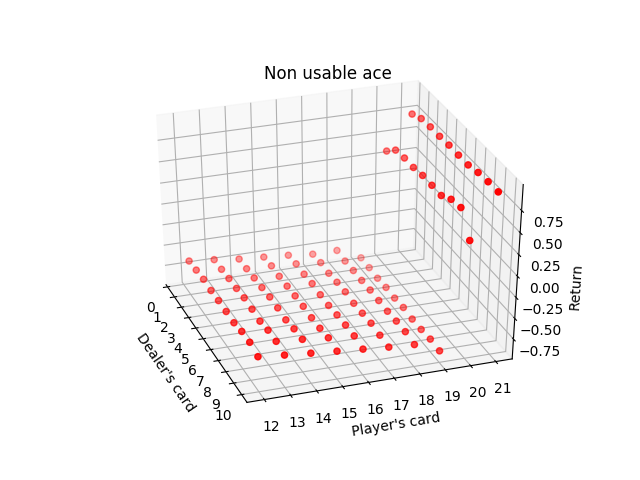

In [7]:
plot(non_usable_ace_values, 'Non usable ace')

<IPython.core.display.Javascript object>


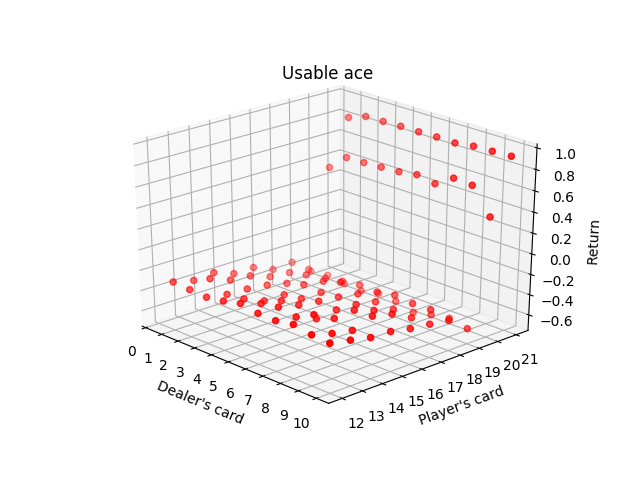

In [8]:
plot(usable_ace_values, 'Usable ace')